In [1]:
#Adult retina
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

/home/mmiihkin/miniconda3/envs/scanpy311/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# Zuckerberg collection of developing retina dataset
file_path = Path.home() / "Downloads" / "74a5e56b-15f0-4965-b6de-7e8dd689d74f.h5ad"

# Load the AnnData object
adata = sc.read_h5ad(file_path)

In [3]:
adata.obs.columns

Index(['n_genes', 'n_counts', 'percent_mito', 'donor_id',
       'assay_ontology_term_id', 'cell_type_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'is_primary_data',
       'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type',
       'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease',
       'sex', 'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid'],
      dtype='object')

/home/mmiihkin/miniconda3/envs/scanpy311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_436595/476730879.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.5, key_added="leiden")


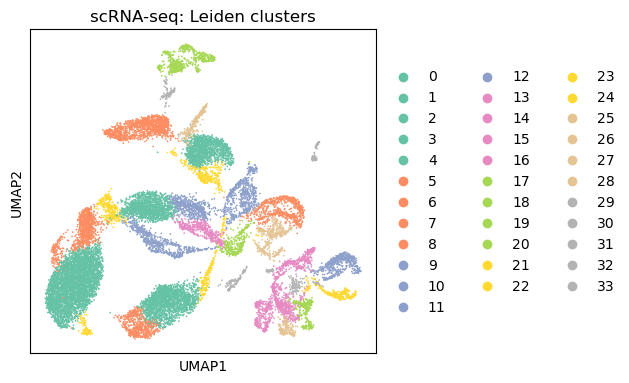

In [8]:
import scanpy as sc
import pandas as pd

#Remove stale diffmap embeddings
adata.obsm.pop("X_diffmap", None)
adata.uns.pop("diffmap_evals", None)   # safe even if missing
adata.uns.pop("diffmap", None)         # optional: remove other diffmap metadata

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.leiden(adata, resolution=1.5, key_added="leiden")
sc.tl.umap(adata, random_state=0)
ax = sc.pl.umap(
    adata,
    color="leiden",
    palette="Set2",
    legend_loc="right margin",
    title="scRNA-seq: Leiden clusters",
    show=False
)

import matplotlib.pyplot as plt
# Rasterize only the point cloud(s)
for coll in ax.collections:
    coll.set_rasterized(True)

plt.tight_layout()
ax.set_aspect("equal")
plt.savefig("umap_retina_scRNAseq_leiden.svg", bbox_inches="tight")
plt.show()


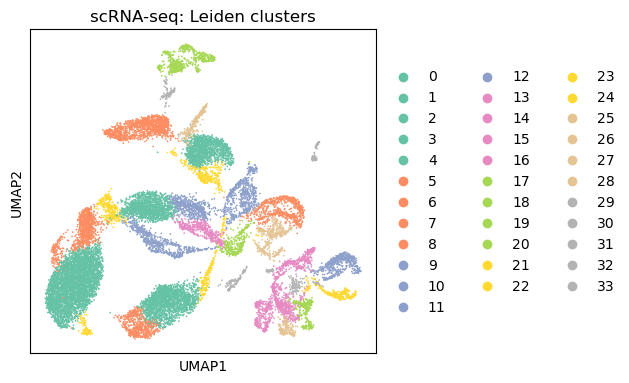

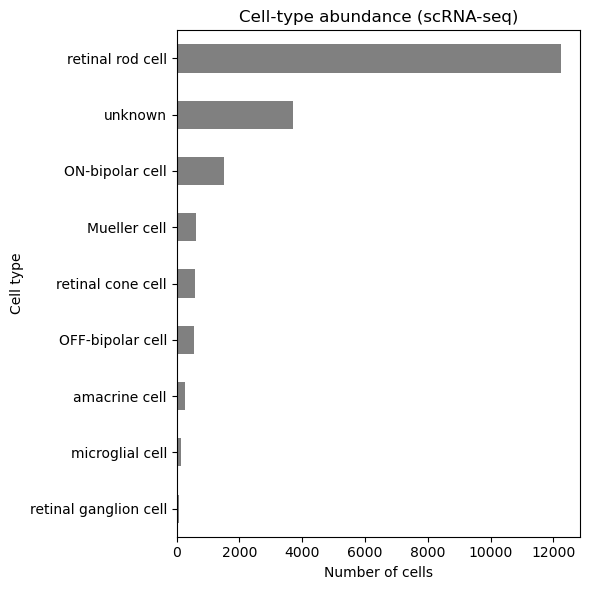

In [9]:
ct = pd.crosstab(
    adata.obs["cell_type"],
    adata.obs["donor_id"]
)

ct

ax = sc.pl.umap(
    adata,
    color="leiden",
    palette="Set2",
    legend_loc="right margin",
    title="scRNA-seq: Leiden clusters",
    show=False
)

import matplotlib.pyplot as plt
# Rasterize only the point cloud(s)
for coll in ax.collections:
    coll.set_rasterized(True)

plt.tight_layout()
ax.set_aspect("equal")
plt.savefig("umap_retina_scRNAseq_leiden.svg", bbox_inches="tight")
plt.show()

counts = adata.obs["cell_type"].value_counts().sort_values()

plt.figure(figsize=(6, 6))
counts.plot(kind="barh", color="gray")

plt.xlabel("Number of cells")
plt.ylabel("Cell type")
plt.title("Cell-type abundance (scRNA-seq)")

plt.tight_layout()

# ✅ save (SVG recommended for text-heavy plots)
plt.savefig("celltype_abundance_scRNAseq_retina.svg", bbox_inches="tight")

plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def chao2(ctab_binary, axis=1):
    incidence = np.sum(ctab_binary, axis=axis)

    S_obs = np.sum(incidence > 0)
    Q1 = np.sum(incidence == 1)
    Q2 = np.sum(incidence == 2)

    S_Chao2 = S_obs + (Q1**2) / (2 * Q2) if Q2 > 0 else S_obs

    return S_obs, Q1, Q2, S_Chao2

def plot_chao2_barplot(ctab_binary, name, axis=1):
    S_obs, _, _, S_Chao2 = chao2(ctab_binary, axis=axis)

    values = [S_obs, S_Chao2]
    labels = ["S_obs", "S_Chao2"]

    plt.figure(figsize=(4, 4))

    bars = plt.bar(
        labels,
        values,
        color="gray",
        edgecolor="black"
    )

    plt.ylabel("Estimated richness")
    plt.title(name)

    # Force y-axis to start at 0 and show full range
    ymax = max(values) * 1.15
    plt.ylim(0, ymax)

    # ✅ Add numbers on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(round(height))}",
            ha="center",
            va="bottom"
        )

    plt.tight_layout()
    plt.savefig(f"{name}_chao2_barplot.svg", bbox_inches="tight")
    plt.show()

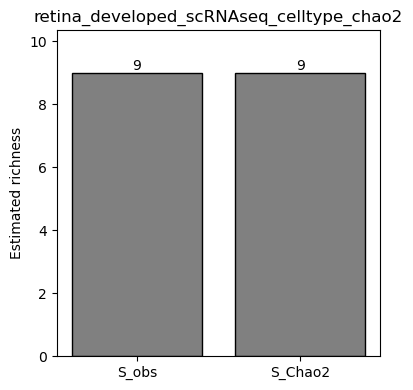

In [12]:
ctab_binary = (ct > 0).astype(int)
plot_chao2_barplot(ctab_binary, name="retina_developed_scRNAseq_celltype_chao2")

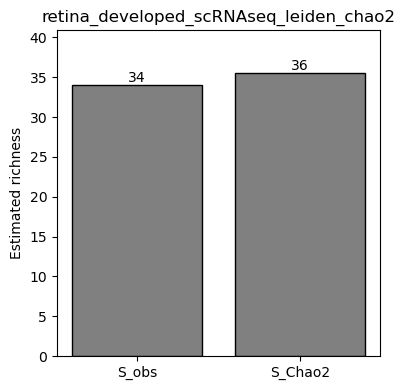

In [13]:
ct = pd.crosstab(
    adata.obs["leiden"],
    adata.obs["donor_id"]
)

ct

ctab_binary = (ct > 0).astype(int)
plot_chao2_barplot(ctab_binary, name="retina_developed_scRNAseq_leiden_chao2")